# Digit Recognition using Deep Learning and Convolutional Networks.

In [10]:
import math
import numpy as np
import cv2 as cv
import time
from scipy import stats
from matplotlib import pyplot as plt
#import skfuzzy as fuzz
import csv
import os
import pandas as pd


## Generating the Test Set

In [11]:
class Region:
    def __init__(self):
        self.xm = 0
        self.ym = 0
        self.xx = 0
        self.yy = 0
        self.xy = 0
        self.xxx = 0
        self.yyy = 0
        self.xxy = 0
        self.xyy = 0
        self.Perimetro = 0
        self.Area = 0
        self.closed = False
        self.edgePoints = []
        self.red = 0
        self.green = 0
        self.blue = 0
    def addPoint(self,x,y,isedge,color):
        self.xm = self.xm + x
        self.ym = self.ym + y
        self.xx = self.xx + x*x
        self.yy = self.yy + y*y
        self.xy = self.xy + x*y
        self.xxx = self.xxx + x*x*x
        self.yyy = self.yyy + y*y*y
        self.xxy = self.xxy + x*x*y
        self.xyy = self.xyy + x*y*y
        self.Area = self.Area + 1
        self.red = self.red + color[0]
        self.green = self.green + color[1]
        self.blue = self.blue + color[2]

        if isedge > 0:
            self.Perimetro = self.Perimetro + 1
            if (isedge & 1) > 0: #up
                self.edgePoints.append((x+0.5,y+0.001))
            if (isedge & 2) > 0: #left
                self.edgePoints.append((x+0.001,y+0.5))
            if (isedge & 4) > 0: #down
                self.edgePoints.append((x+0.5,y+0.999))
            if (isedge & 8) > 0: #right
                self.edgePoints.append((x+0.999,y+0.5))
    def addRegion(self,region):
        if (self.closed == False) and (region.closed == False) and (region.Area > 0):
            self.xm = self.xm + region.xm
            self.ym = self.ym + region.ym
            self.xx = self.xx + region.xx
            self.yy = self.yy + region.yy
            self.xy = self.xy + region.xy
            self.xxx = self.xxx + region.xxx
            self.yyy = self.yyy + region.yyy
            self.xxy = self.xxy + region.xxy
            self.xyy = self.xyy + region.xyy
            self.Area = self.Area + region.Area
            self.Perimetro = self.Perimetro + region.Perimetro
            self.red = self.red + region.red
            self.green = self.green + region.green
            self.blue = self.blue + region.blue
            for n in range(len(region.edgePoints)):
                self.edgePoints.append(region.edgePoints[n])
    def closeRegion(self):
        if (self.Area > 0) and (self.closed == False):
            self.xm = self.xm/self.Area
            self.ym = self.ym/self.Area
            self.xx = self.xx/self.Area - self.xm*self.xm
            self.yy = self.yy/self.Area - self.ym*self.ym
            self.xy = self.xy/self.Area - self.xm*self.ym
            self.red = self.red/self.Area
            self.green = self.green/self.Area
            self.blue = self.blue/self.Area
            self.closed = True


In [12]:
def smoothPointSet(points,steps):
    lpts = len(points)
    for stp in range(steps):
        apt = np.array(points)
        for n in range(lpts):
            bidx = (n + lpts - 1) % lpts
            uidx = (n + lpts + 1) % lpts
            points[n] = ((apt[bidx][0]+apt[n][0]+apt[uidx][0])/3,(apt[bidx][1]+apt[n][1]+apt[uidx][1])/3)
    return points

In [13]:
def getInvariantFeatures(points, displayIndividual = True):
    outlinePoints = points

    # Convert the list of points to integer coordinates
    points = np.array([(int(pt[0]), int(pt[1])) for pt in outlinePoints[0]])

    xMin, yMin = np.min(points, axis=0)
    xMax, yMax = np.max(points, axis=0)

    # Create a binary image that fits the bounding box (a brack BG image)
    binary_image = np.zeros((yMax - yMin + 1, xMax - xMin + 1), dtype=np.uint8)
    shifted_points = points - [xMin, yMin]

    # Draw the digit in the binary image (white FG)
    for x, y in shifted_points:
        binary_image[y, x] = 1

    return xMin, yMin, xMax, yMax

In [14]:
def orderPointSet(opoints,EdgeImage):
    orderpointsList = []
    if len(opoints) > 0:
        points = opoints.copy()
        neigbors = np.array([(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1),(0,0)])*0.5
        plen = len(points)
        n = 0
        last = 0
        inserted = 0
        orderpoints = []
        orderpoints.append(points[0])
        points.pop(0)
        lastidx = 0
        who = 0
        for inserted in range(plen-1):
            n = 0
            cpt = np.array(orderpoints[last])
            edgetype = EdgeImage[int(cpt[1]),int(cpt[0])]
            dis = 1
            thepoints = np.array(points)
            thesum = np.sum(abs(thepoints-cpt),axis=1)
            lastdir = np.sum(np.square(neigbors-neigbors[lastidx]),axis=1)
            dis = 10
            idx = lastidx;
            for n in range(len(points)):
                if thesum[n] <= 2:
                    npoints = cpt + neigbors
                    theNsum = np.sum(np.abs(npoints-thepoints[n]),axis=1) + 0.01*lastdir
                    for nn in range(8):
                        nedgetype = EdgeImage[int(npoints[nn,1]),int(npoints[nn,0])]
                        dist = theNsum[nn] + 0.001*((edgetype ^ nedgetype) > 0)
                        if dist < dis:
                            dis = dist
                            idx = nn
                            who = n
            if dis < 1.0:
                lastidx = idx
                orderpoints.append(points[who])
                points.pop(who)
            else:
                if len(orderpoints) > 2:
                    orderpointsList.append(orderpoints)
                orderpoints = []
                orderpoints.append(points[0])
                points.pop(0)
                last = 0
            last = len(orderpoints) - 1
        if len(orderpoints) > 2:
            orderpointsList.append(orderpoints)
    return orderpointsList

In [15]:

def SegmentationRegions(image,colorimg):
    regions = []
    si,sj = image.shape;
    fimage = image.astype(np.int16)
    EdgeImage = image.astype(np.int16)

    regionlabels = image[:,:];
    regionlabels = regionlabels.astype(np.int32)
    shortlabellut = np.zeros((int(si*sj/100+1),), dtype=np.int32)
    labellut = shortlabellut
    upKernel = np.array((
    [0, -1, 0],
    [0, 1, 0],
    [0, 0, 0]), dtype=np.int16)
    upsameI = abs(cv.filter2D(fimage,-1,upKernel)) == 0
    leftKernel = np.array((
    [0, 0, 0],
    [-1, 1, 0],
    [0, 0, 0]), dtype=np.int16)
    leftsameI = abs(cv.filter2D(fimage,-1,leftKernel)) == 0
    downKernel = np.array((
    [0, 0, 0],
    [0, 1, 0],
    [0, -1, 0]), dtype=np.int16)
    downsameI = abs(cv.filter2D(fimage,-1,downKernel)) == 0
    rightKernel = np.array((
    [0, 0, 0],
    [0, 1, -1],
    [0, 0, 0]), dtype=np.int16)
    rightsameI = abs(cv.filter2D(fimage,-1,rightKernel)) == 0
    currentlabel=0
    uplabelArray = regionlabels[0,:]
    upsame = False
    leftsame = False
    thelabel = 0
    uplabel = 0
    leftlabel = 0
    regions.append(Region())
    for i in range(si):
        leftlabel = labellut[regionlabels[i,0]]
        for j in range(sj):
            color = colorimg[i,j,:]
            thelabel = leftlabel
            upsame = False
            leftsame = False
            EdgeImage[i,j] = 1*(not upsameI[i,j]) +  2*(not leftsameI[i,j]) + 4*(not downsameI[i,j]) + 8*(not rightsameI[i,j])
            if i>0:
                uplabel = uplabelArray[j]
                upsame = upsameI[i,j]
                if upsame:
                    thelabel = uplabel
            if j>0:
                leftsame = leftsameI[i,j]
                if leftsame:
                    if thelabel > leftlabel:
                        thelabel = leftlabel
                    if upsame:
                        thelabel = labellut[thelabel]
                        labellut[leftlabel] = thelabel
                        labellut[uplabel] = thelabel
            if (not(upsame) and  not(leftsame)):
                currentlabel = currentlabel + 1
                regions.append(Region())
                thelabel = currentlabel
                if (currentlabel >= labellut.size):
                    labellut = np.append(labellut, shortlabellut)
                labellut[currentlabel] = currentlabel
            else:
                thelabel = labellut[thelabel]
            regionlabels[i,j] = thelabel
            regions[thelabel].addPoint(j,i,EdgeImage[i,j],color)
            leftlabel = thelabel
        uplabelArray = regionlabels[i,:]
    print(len(regions))
    lreg = len(regions)
    changes = 1
    while changes > 0:
        changes = 0
        for idx in range(lreg):
            newlabel = labellut[idx]
            if regions[idx].Area > 0 and idx != newlabel:
                changes = changes + 1
                regions[newlabel].addRegion(regions[idx])
                regions[idx].__init__()
            labellut[idx] = labellut[newlabel]
        print(changes)
    closed = 0
    for n in range(lreg):
        if (n == labellut[n]) and (regions[n].Area > 0):
            closed = closed + 1
            regions[n].closeRegion()
    print(closed)
    regionlabels = labellut[regionlabels]
    return regionlabels, regions, EdgeImage


In [16]:
PERIMETERS = [
    (300, 2000), # 0
    (100, 700),
    (150, 700), # 2
    (250, 500),
    (200, 700), # 4
    (200, 1000),
    (200, 700), # 6
    (150, 700),
    (400, 700), # 8
    (200, 700)
]

PERIMETERS_TEST = [250, 1000]


#########################################################################

EXTRACTION OF ID Den

#########################################################################


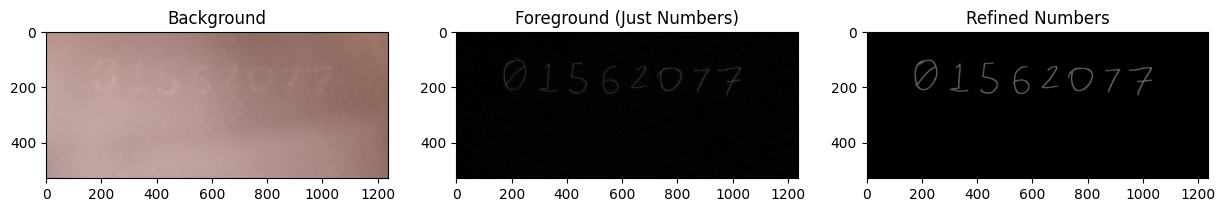

878
860
14
0
17


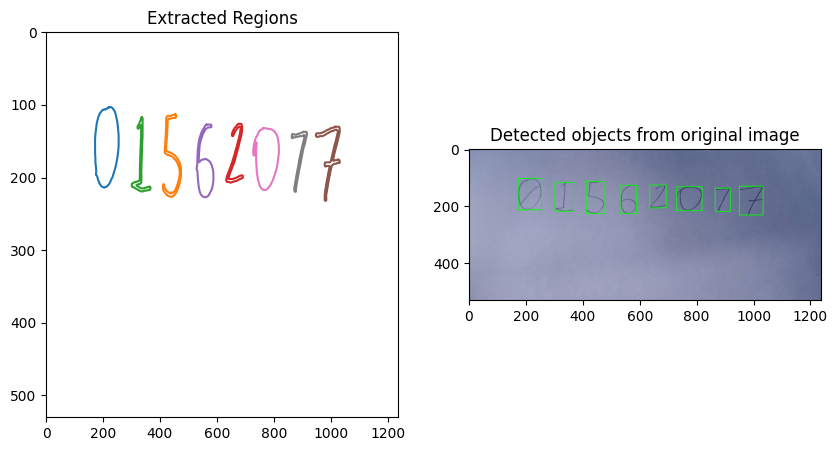

#########################################################################

EXTRACTION OF ID Luis

#########################################################################


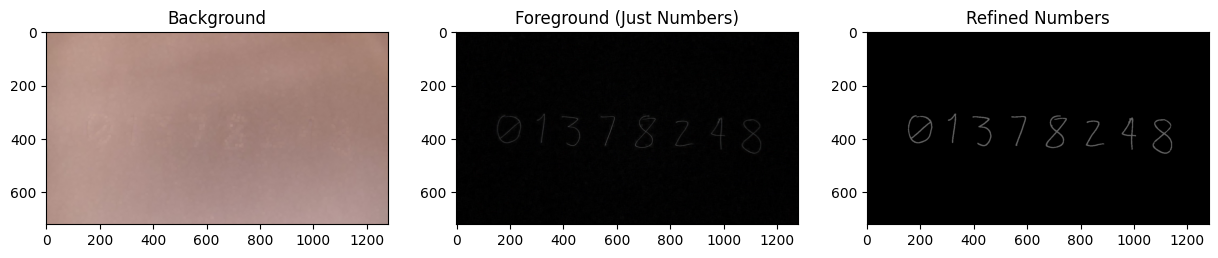

971
956
12
0
14


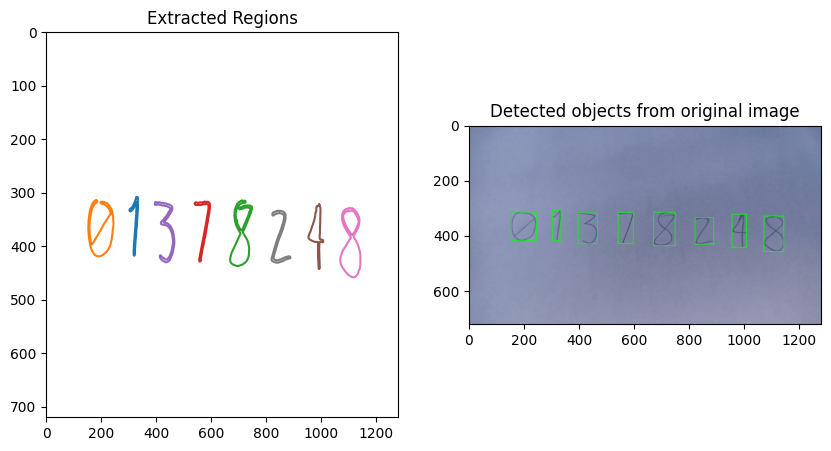

#########################################################################

EXTRACTION OF ID Rivers

#########################################################################


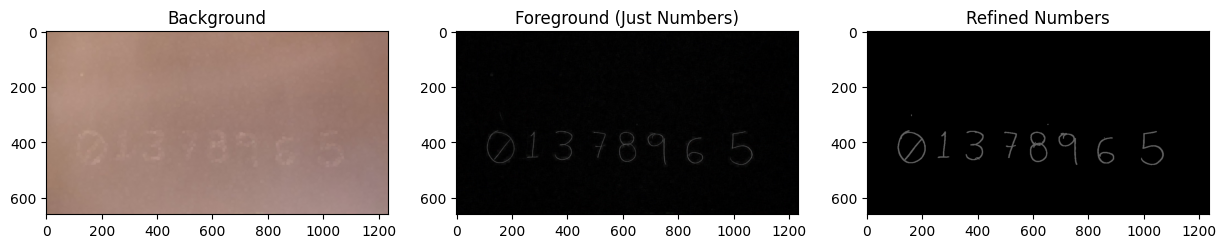

768
745
16
0
22


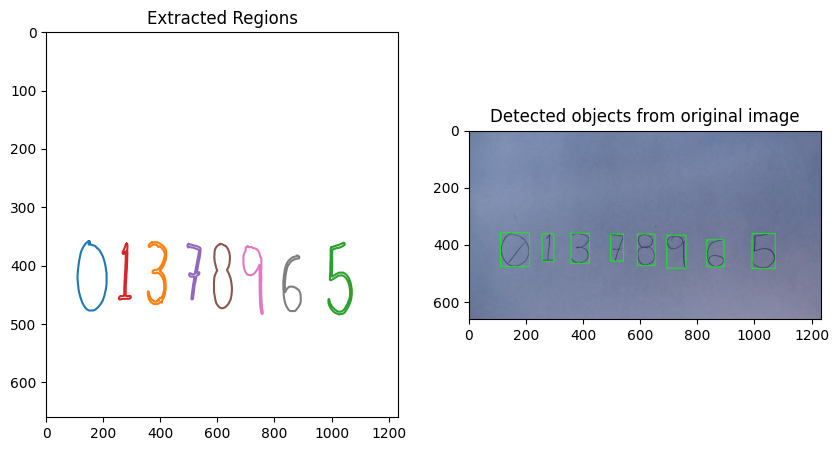

In [22]:


for digit in ['Den', 'Luis', 'Rivers']:

    print("#########################################################################")
    print()
    print(f"EXTRACTION OF ID {digit}")
    print()
    print("#########################################################################")

    frame = cv.imread(os.path.join("digitsTest", f"{digit}.jpeg"))
    rawImg = frame.copy()

    kernel = np.ones((5,5),np.uint8)
    bkgnd = cv.dilate(frame,kernel,iterations = 1)
    bkgnd = cv.dilate(bkgnd,kernel,iterations = 1)

    frame = (bkgnd - frame)
    frgnd = frame.copy()

    kernel = np.ones((3,3),np.uint8)
    frame = cv.dilate(frame,kernel,iterations = 1)

    green = frame[:,:,2]
    ret,img = cv.threshold(green, 32, 100, 0)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(cv.cvtColor(bkgnd, cv.COLOR_BGR2RGB))
    ax[0].set_title("Background")

    ax[1].imshow(cv.cvtColor(frgnd, cv.COLOR_BGR2RGB))
    ax[1].set_title("Foreground (Just Numbers)")

    ax[2].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    img_to_save = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    ax[2].set_title("Refined Numbers")
    plt.show()

    # ###################
    labeled, regions, EdgeImage = SegmentationRegions(img,frame)

    labeled = labeled % 21

    img = cv.normalize(labeled, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    im_color = cv.applyColorMap(img, cv.COLORMAP_HSV)
    im_color = cv.medianBlur(im_color,3)
    RGB_im = cv.cvtColor(im_color, cv.COLOR_BGR2RGB)

    # ###################

    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    boundaries = []
    for n in range(len(regions)-2):
        idx = n+2
        if regions[idx].Perimetro > PERIMETERS_TEST[0]:
            if regions[idx].Perimetro < PERIMETERS_TEST[1]:

                pointlist = orderPointSet(regions[idx].edgePoints, EdgeImage)
                smoothpoints = np.array(smoothPointSet(pointlist[0],3))
                xMin, yMin, xMax, yMax = getInvariantFeatures(pointlist, displayIndividual=False)

                boundaries.append(((xMin, yMin), (xMax, yMax)))

                ax[0].plot(smoothpoints[:,0],smoothpoints[:,1])

    ax[0].set_ylim(frame.shape[0], 0)
    ax[0].set_xlim(0, frame.shape[1])
    ax[0].set_title("Extracted Regions")

    boundedImg = rawImg.copy()
    for ind, (startPoint, endPoint) in enumerate(boundaries):
        cv.rectangle(boundedImg, startPoint, endPoint, (0,255,0), 2)
        #print(rawImg.shape, 'raw image shape')
        xd = cv.cvtColor(img_to_save, cv.COLOR_BGR2RGB)[startPoint[1]:endPoint[1], startPoint[0]: endPoint[0]]
        cv.imwrite(f'TestSet/{digit}/{ind}.jpg', xd)        

    ax[1].imshow(boundedImg)
    ax[1].set_title("Detected objects from original image")
    plt.show()
    



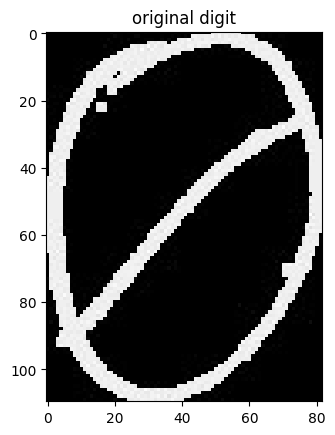

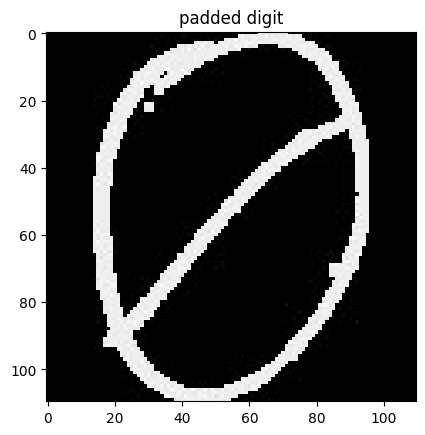

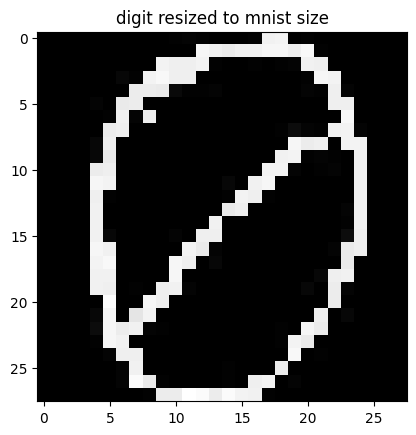

In [31]:
for person in ['Den', 'Luis', 'Rivers']:
    files = sorted(os.listdir(f'TestSet/{person}'))
    for file in files:
        img = cv.imread(f'TestSet/{person}/{file}', cv.IMREAD_GRAYSCALE)
        if person == 'Den' and file == '0.jpg':
            plt.imshow(img, cmap='gray')
            plt.title('original digit')
            plt.show()
        #large side 
        ls = max(img.shape)
        #large index
        li = img.shape.index(ls)
        # pad index
        pi = 1 - li
        # pad width
        pw = [[0, 0], [0, 0]]
        # pad size
        ps = abs(img.shape[0] - img.shape[1])
        pw[pi] = [ps // 2, ps // 2]
        xd = np.pad(img, pad_width=pw, mode='constant')
        if person == 'Den' and file == '0.jpg':
            plt.imshow(xd, cmap='gray')
            plt.title('padded digit')
            plt.show()
        mnist_size = cv.resize(xd, (28, 28), 
            interpolation = cv.INTER_NEAREST)
        if person == 'Den' and file == '0.jpg':
            plt.imshow(mnist_size, cmap='gray')
            plt.title('digit resized to mnist size')
            plt.show()
        cv.imwrite(f'TestSet/{person}/{file[:-4]}ms.jpg', mnist_size)


